# converted to mongodb data

In [6]:
from pymongo import MongoClient
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import numpy as np

# Connect to MongoDB (Adjust the connection string as necessary)
client = MongoClient('mongodb://localhost:27017/')
db = client['vaers']  # Change 'your_database_name' to your database name
collection = db['reports']  # Change 'your_collection_name' to your collection name


# Mortalities per Year (1990-2023)

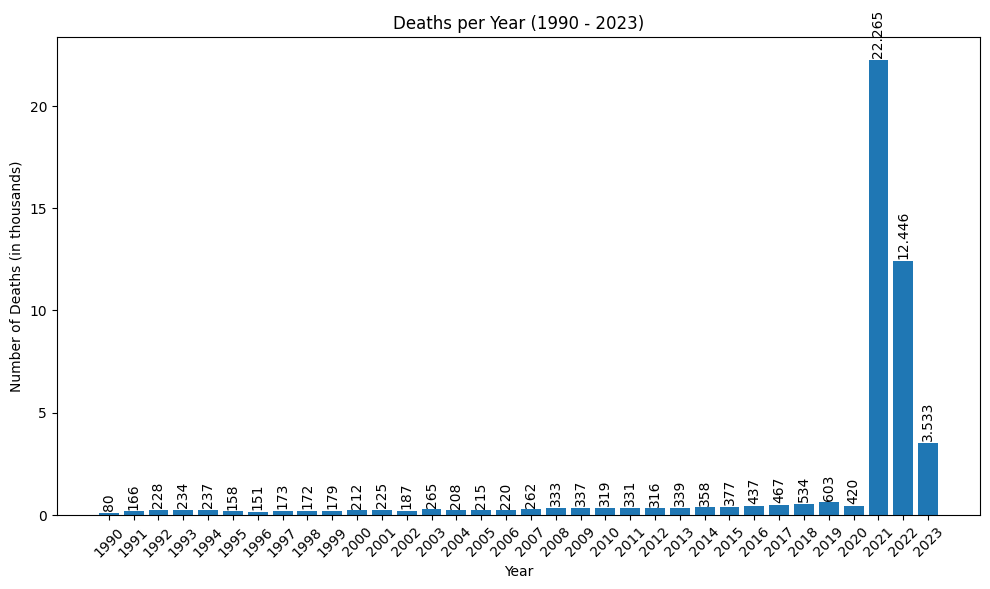

In [104]:
# Custom formatter function for y-axis in thousands
def thousands_formatter(y, pos):
    return f'{int(y / 1000)}'

# MongoDB aggregation pipeline to calculate deaths per year
pipeline = [
    {"$match": {"DIED": "Y"}},  # Match documents where DIED field is "Y"
    {"$addFields": {"year": {"$year": {"$toDate": "$RECVDATE"}}}},  # Extract year from RECVDATE
    {"$group": {"_id": "$year", "count": {"$sum": 1}}},  # Group by year and count deaths
    {"$sort": {"_id": 1}}  # Sort by year in ascending order
]

# Execute the aggregation pipeline
deaths_per_year = list(collection.aggregate(pipeline))

# Extract years and death counts from the aggregation result
years = [entry["_id"] for entry in deaths_per_year]
death_counts = [entry["count"] for entry in deaths_per_year]

# Plotting the data
plt.figure(figsize=(10, 6))
bars = plt.bar(years, death_counts)

# Set the y-axis formatter for thousands
formatter = FuncFormatter(thousands_formatter)
plt.gca().yaxis.set_major_formatter(formatter)

plt.xlabel('Year')
plt.ylabel('Number of Deaths (in thousands)')
plt.title('Deaths per Year (1990 - 2023)')

# Annotating each bar with its value, formatted with a dot for thousands
for bar in bars:
    height = bar.get_height()
    formatted_height = f'{int(height):,}'.replace(',', '.')  # Format with a dot for thousands
    plt.text(bar.get_x() + bar.get_width() / 2, height + 100, formatted_height,
             ha='center', va='bottom', rotation=90)

plt.xticks(years, rotation=45)

plt.tight_layout()
plt.savefig('/Users/sep/PycharmProjects/Masterarbeit/Plots/Data_Exploration/Mortality_Rate/Deaths_per_Year.png')
plt.show()

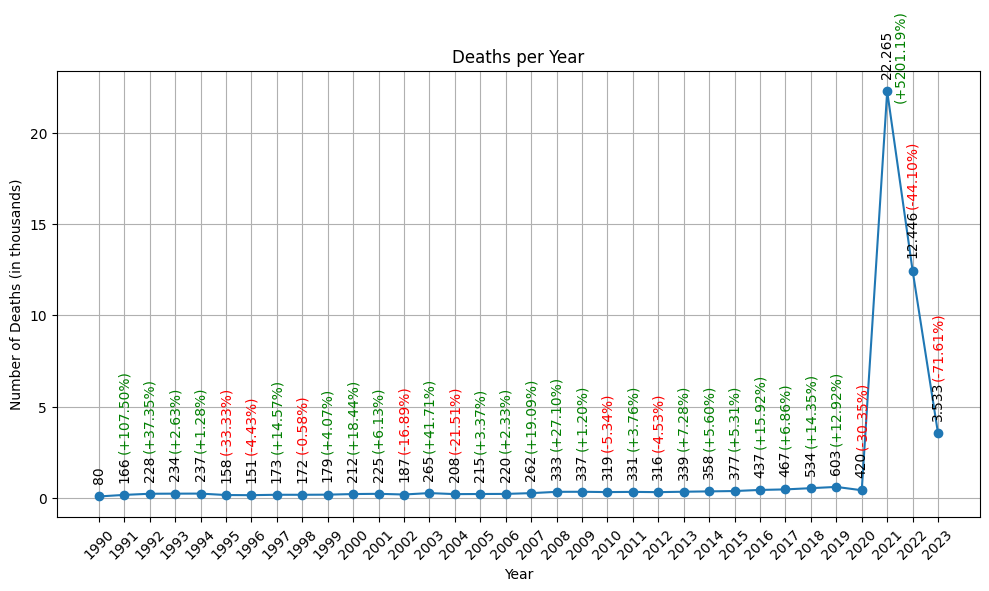

In [105]:
# Custom formatter function for y-axis in thousands
def thousands_formatter(y, pos):
    return f'{int(y / 1000)}'

# Connect to MongoDB
client = MongoClient("mongodb://localhost:27017")
db = client["vaers"]
collection = db["reports"]

deaths_per_year = {}

# Aggregate death count per year
pipeline = [
    {"$match": {"DIED": "Y"}},
    {"$group": {"_id": {"$year": "$RECVDATE"}, "count": {"$sum": 1}}}
]

# Execute the aggregation pipeline
result = collection.aggregate(pipeline)

# Convert the result to a dictionary
for entry in result:
    year = entry["_id"]
    deaths = entry["count"]
    deaths_per_year[year] = deaths

# Convert dictionary to a DataFrame
df = pd.DataFrame.from_dict(deaths_per_year, orient='index', columns=['Deaths'])
df.index.name = 'Year'

# Sort the DataFrame by index (year)
df = df.sort_index()

# Calculate percentage change and add it to the DataFrame
df['Percentage Change'] = df['Deaths'].pct_change() * 100
df['Percentage Change'] = df['Percentage Change'].fillna(0)  # Fill NaN (first row) with 0

# Plotting the data as a 2D line graph with original matplotlib blue color
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Deaths'], marker='o', linestyle='-')  # Use 'b' for original blue color
plt.xlabel('Year')
plt.ylabel('Number of Deaths (in thousands)')
plt.title('Deaths per Year')

# Set the y-axis formatter for thousands
formatter = FuncFormatter(thousands_formatter)
plt.gca().yaxis.set_major_formatter(formatter)

# Annotate each point with its value (formatted_deaths) in black
for year, deaths in zip(df.index, df['Deaths']):
    formatted_deaths = f'{int(deaths):,}'.replace(',', '.')  # Format with a dot for thousands
    plt.annotate(formatted_deaths, (year, deaths + 100), textcoords="offset points", xytext=(0, 10),
                 ha='center', fontsize=10, rotation=90, color='black')

# Annotate each point with its percentage change (pct_change) in red or green
for year, pct_change, formatted_deaths in zip(df.index, df['Percentage Change'], df['Deaths']):
    color = 'green' if pct_change > 0 else 'red' if pct_change < 0 else 'black'
    annotation_text = f'({pct_change:+.2f}%)'
    
    # Skip annotating the percentage value for the first year
    if year == df.index[0]:
        continue
    
    # Set offset based on formatted_deaths value
    if formatted_deaths < 1000:
        offset = 1650
        xoffset = 0
    elif formatted_deaths < 10000:
        offset = 2300
        xoffset = 0
    elif formatted_deaths < 20000:
        offset = 2800
        xoffset = 0
    else:
        offset = -1200
        xoffset = 0.5
    
    plt.annotate(annotation_text, (year + xoffset, formatted_deaths + offset), textcoords="offset points", xytext=(0, 10),
                 ha='center', fontsize=10, rotation=90, color=color)

# Set x-ticks to the years in the dataset
plt.xticks(df.index, rotation=45)

plt.tight_layout()
plt.grid(True)
plt.savefig('/Users/sep/PycharmProjects/Masterarbeit/Plots/Data_Exploration/Mortality_Rate/Deaths_per_Year_dotted.png')
plt.show()

# Mortality Rate per Year (1990-2023)

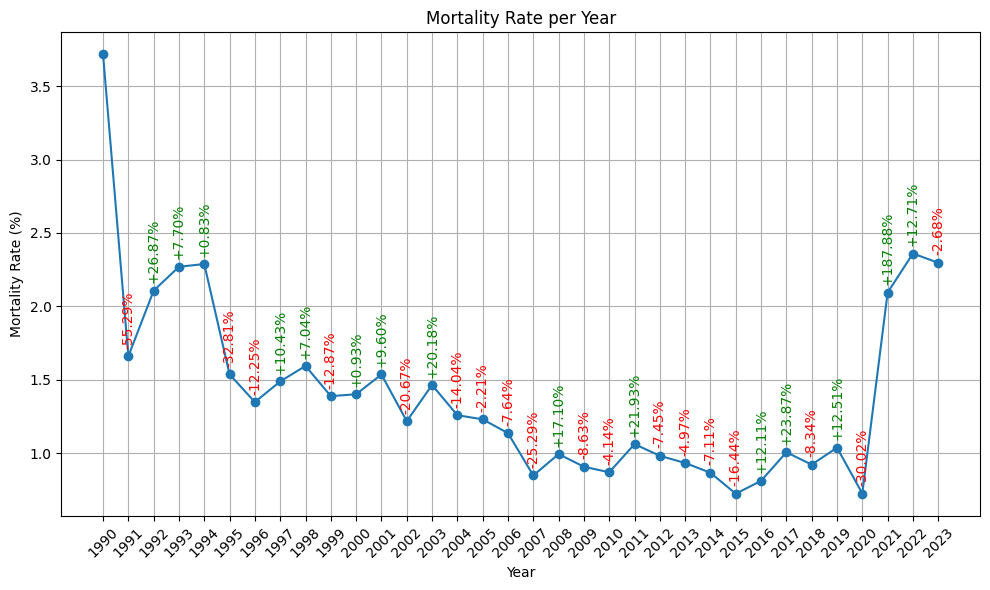

In [106]:
# MongoDB aggregation pipeline to calculate mortality rate per year
pipeline = [
    {"$group": {
        "_id": {"$year": "$RECVDATE"},
        "total_entries": {"$sum": 1},
        "deaths": {"$sum": {"$cond": [{"$eq": ["$DIED", "Y"]}, 1, 0]}}
    }},
    {"$project": {
        "_id": 0,
        "year": "$_id",
        "total_entries": "$total_entries",
        "deaths": "$deaths",
        "mortality_rate": {"$cond": [{"$gt": ["$total_entries", 0]}, {"$multiply": [{"$divide": ["$deaths", "$total_entries"]}, 100]}, 0]}
    }},
    {"$sort": {"year": 1}}
]

# Execute the aggregation pipeline
result = list(collection.aggregate(pipeline))

# Extracting years, total_entries, deaths, and mortality rates from the aggregation result
years = [entry['year'] for entry in result]
total_entries = [entry['total_entries'] for entry in result]
deaths = [entry['deaths'] for entry in result]
mortality_rates = [entry['mortality_rate'] for entry in result]

# Calculate the percentage change compared to the previous year
percent_changes = {}
previous_rate = None
for i in range(1, len(mortality_rates)):
    year = years[i]
    rate = mortality_rates[i]
    previous_rate = mortality_rates[i - 1]
    percent_change = ((rate - previous_rate) / previous_rate) * 100 if previous_rate > 0 else 0
    percent_changes[year] = percent_change

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(years, mortality_rates, marker='o')

plt.xlabel('Year')
plt.ylabel('Mortality Rate (%)')
plt.title('Mortality Rate per Year')
plt.xticks(years, rotation=45)

# Annotating each point with the percentage change
for year, percent_change in percent_changes.items():
    x_pos = years.index(year)
    y_pos = mortality_rates[x_pos]
    color = 'green' if percent_change > 0 else 'red'
    sign = '+' if percent_change > 0 else ''
    plt.text(year, y_pos + 0.05, f"{sign}{percent_change:.2f}%", rotation=90, color=color, va='bottom', ha='center')

plt.grid(True)
plt.tight_layout()
plt.savefig('/Users/sep/PycharmProjects/Masterarbeit/Plots/Data_Exploration/Mortality_Rate/Mortality_Rate_per_Year.png')
plt.show()


# Highest Mortality Rates per Vaccine Type (1990-2023)

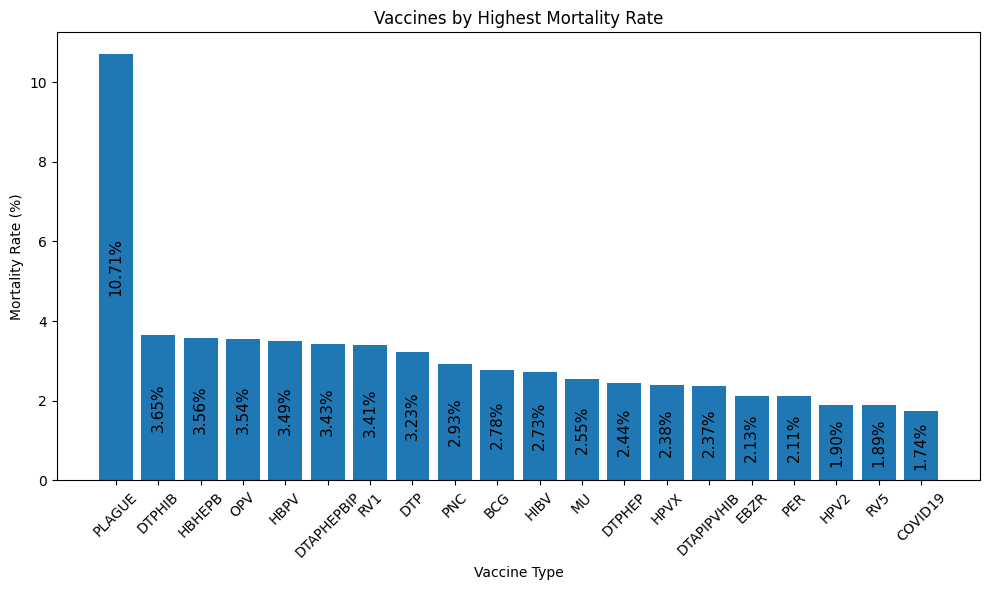

In [1]:
import pandas as pd

vaccine_counts = {}
death_ids = {}

for year in range(1990, 2024):
    try:
        # Load data with only the required columns
        mortality_data_path = f"/Users/sep/Documents/HAW/Masterarbeit/Daten.nosync/{year}VAERSDATA.csv"
        vaccine_data_path = f"/Users/sep/Documents/HAW/Masterarbeit/Daten.nosync/{year}VAERSVAX.csv"
        mortality_data = pd.read_csv(mortality_data_path, encoding="Iso-8859-1", low_memory=False, usecols=['VAERS_ID', 'DIED'])
        vaccine_data = pd.read_csv(vaccine_data_path, encoding="Iso-8859-1", low_memory=False, usecols=['VAERS_ID', 'VAX_TYPE'])

        # Process vaccine data
        for index, row in vaccine_data.iterrows():
            vax_type = row['VAX_TYPE']
            # Combine "COVID19" and "COVID19-2" into "COVID19"
            if vax_type == "COVID19-2":
                vax_type = "COVID19"
            vaccine_counts[vax_type] = vaccine_counts.get(vax_type, 0) + 1

        # Process mortality data
        deaths_data = mortality_data[mortality_data['DIED'] == 'Y']
        for index, row in deaths_data.iterrows():
            vaers_id = row['VAERS_ID']
            death_vaccine_data = vaccine_data[vaccine_data['VAERS_ID'] == vaers_id]
            for _, vax_row in death_vaccine_data.iterrows():
                vax_type = vax_row['VAX_TYPE']
                # Combine "COVID19" and "COVID19-2" into "COVID19"
                if vax_type == "COVID19-2":
                    vax_type = "COVID19"
                if vax_type in death_ids:
                    if vaers_id not in death_ids[vax_type]:
                        death_ids[vax_type].add(vaers_id)
                else:
                    death_ids[vax_type] = {vaers_id}
    except Exception as e:
        print(f"An error occurred for year {year}: {e}")

# Calculate mortality rates
mortality_rates = {}
for vax_type in vaccine_counts:
    deaths = len(death_ids.get(vax_type, []))
    mortality_rate = (deaths / vaccine_counts[vax_type]) * 100 if vaccine_counts[vax_type] > 0 else 0
    mortality_rates[vax_type] = mortality_rate

# Sort and select top 20 vaccines
top_20_vaccines = sorted(mortality_rates.items(), key=lambda item: item[1], reverse=True)[:20]

# Plotting
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
bars = plt.bar([item[0] for item in top_20_vaccines], [item[1] for item in top_20_vaccines])
plt.xlabel('Vaccine Type')
plt.ylabel('Mortality Rate (%)')
plt.title('Vaccines by Highest Mortality Rate')

# Annotate each bar with its value
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval/2, f'{yval:.2f}%', ha='center', va='center', fontsize=11, color='black', rotation=90)

plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('/Users/sep/PycharmProjects/Masterarbeit/Plots/Data_Exploration/Mortality_Rate/Highest_Mortality_Rate_per_Vaccine_Type.png')
plt.show()


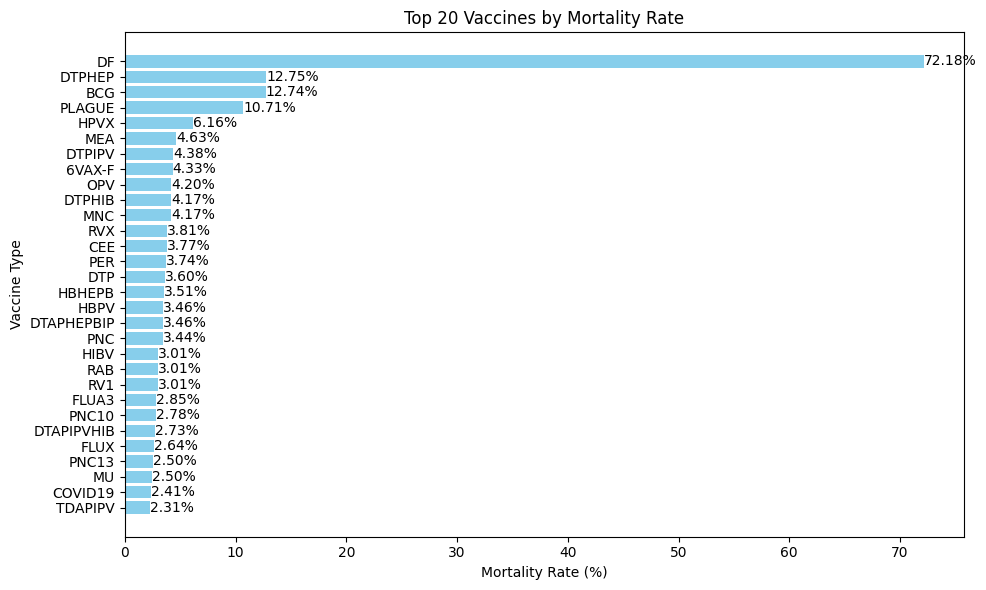

In [93]:
pipeline = [
    {
        "$unwind": "$vax_data"
    },
    {
        "$project": {
            "VAX_TYPE": {
                "$cond": {
                    "if": { "$eq": ["$vax_data.VAX_TYPE", "COVID19-2"] },
                    "then": "COVID19",
                    "else": "$vax_data.VAX_TYPE"
                }
            },
            "DIED": 1
        }
    },
    {
        "$group": {
            "_id": "$VAX_TYPE",
            "count": { "$sum": 1 },
            "deaths": {
                "$sum": {
                    "$cond": [{ "$eq": ["$DIED", "Y"] }, 1, 0]
                }
            }
        }
    },
    {
        "$project": {
            "Vaccine Type": "$_id",
            "Total Vaccine Occurrences": "$count",
            "Total Deaths": "$deaths",
            "Mortality Rate (%)": {
                "$multiply": [
                    { "$divide": ["$deaths", "$count"] },
                    100
                ]
            },
            "_id": 0
        }
    },
    {
        "$sort": { "Mortality Rate (%)": -1 }
    },
    {
        "$limit": 30
    }
]

# Execute the pipeline
result = list(collection.aggregate(pipeline))

# Extract data for plotting
vaccine_types = [entry["Vaccine Type"] for entry in result]
mortality_rates = [entry["Mortality Rate (%)"] for entry in result]

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(vaccine_types, mortality_rates, color='skyblue')
plt.xlabel('Mortality Rate (%)')
plt.ylabel('Vaccine Type')
plt.title('Top 20 Vaccines by Mortality Rate')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest rate at the top

for bar, rate in zip(bars, mortality_rates):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f'{rate:.2f}%', 
             va='center', ha='left')

plt.tight_layout()
plt.show()


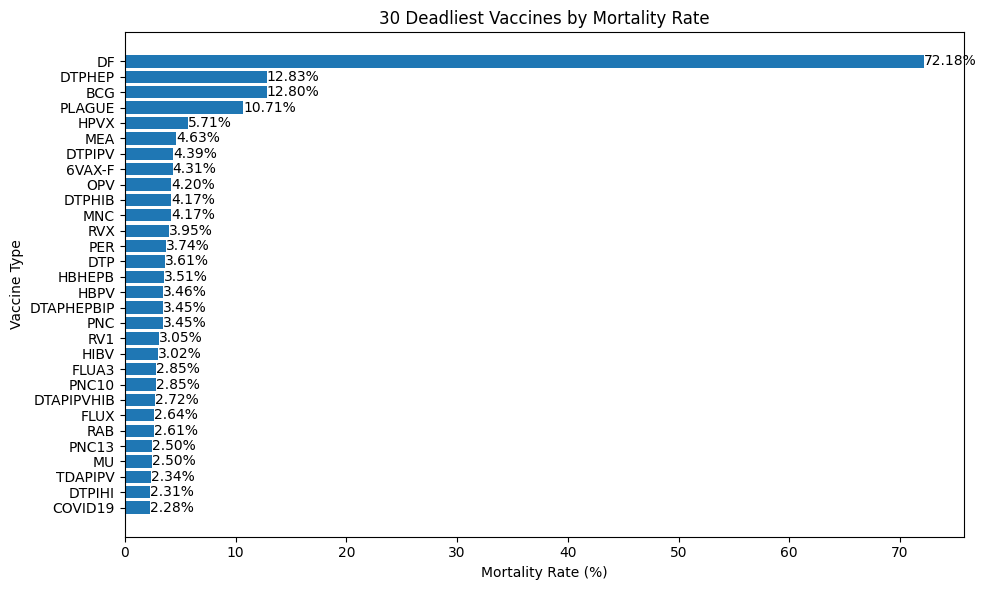

In [107]:
pipeline = [
    {
        "$unwind": "$vax_data"
    },
    {
        "$group": {
            "_id": {
                "VAERS_ID": "$VAERS_ID",
                "VAX_TYPE": {
                    "$cond": {
                        "if": { "$eq": ["$vax_data.VAX_TYPE", "COVID19-2"] },
                        "then": "COVID19",
                        "else": "$vax_data.VAX_TYPE"
                    }
                }
            },
            "DIED": { "$first": "$DIED" }
        }
    },
    {
        "$group": {
            "_id": "$_id.VAX_TYPE",
            "count": { "$sum": 1 },
            "deaths": {
                "$sum": {
                    "$cond": [{ "$eq": ["$DIED", "Y"] }, 1, 0]
                }
            }
        }
    },
    {
        "$project": {
            "Vaccine Type": "$_id",
            "Total Vaccine Occurrences": "$count",
            "Total Deaths": "$deaths",
            "Mortality Rate (%)": {
                "$multiply": [
                    { "$divide": ["$deaths", "$count"] },
                    100
                ]
            },
            "_id": 0
        }
    },
    {
        "$sort": { "Mortality Rate (%)": -1 }
    },
    {
        "$limit": 30
    }
]

# Execute the pipeline with allowDiskUse option
result = list(collection.aggregate(pipeline, allowDiskUse=True))


# Extract data for plotting
vaccine_types = [entry["Vaccine Type"] for entry in result]
mortality_rates = [entry["Mortality Rate (%)"] for entry in result]

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.barh(vaccine_types, mortality_rates)
plt.xlabel('Mortality Rate (%)')
plt.ylabel('Vaccine Type')
plt.title('30 Deadliest Vaccines by Mortality Rate')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest rate at the top

for bar, rate in zip(bars, mortality_rates):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f'{rate:.2f}%', 
             va='center', ha='left')

plt.tight_layout()
plt.savefig('/Users/sep/PycharmProjects/Masterarbeit/Plots/Data_Exploration/Mortality_Rate/Highest_Mortality_Rate_per_Vaccine_Type.png')
plt.show()


In [89]:
vaccine_types

['PNC',
 'TD',
 'RV',
 'RVX',
 'FLUX(H1N1)',
 'YF',
 'FLUA3',
 'MMR',
 'CHOL',
 'COVID19',
 'DTAPH',
 'PPV',
 'HEP',
 'BCG',
 'VARCEL',
 'HPV9',
 'RV5',
 'CEE',
 'MU',
 'FLUA4',
 'TYP',
 'DTPPVHBHPB',
 'HPV2',
 'FLU4',
 'PLAGUE',
 'MM',
 'RAB',
 'DPP',
 'MEA',
 'DTPHIB']

In [59]:
import pandas as pd

plague_vaccine_type = "PLAGUE"
plague_vaccine_count = 0
plague_deaths_count = 0
vaccine_death_counts = {}

for year in range(1990, 2024):
    try:
        # Load data with only the required columns
        vaccine_data_path = f"/Users/sep/Documents/HAW/Masterarbeit/Daten.nosync/{year}VAERSVAX.csv"
        vaccine_data = pd.read_csv(vaccine_data_path, encoding="Iso-8859-1", low_memory=False, usecols=['VAERS_ID', 'VAX_TYPE'])

        # Process vaccine data
        for index, row in vaccine_data.iterrows():
            if row['VAX_TYPE'] == plague_vaccine_type:
                plague_vaccine_count += 1

        # Process mortality data
        mortality_data_path = f"/Users/sep/Documents/HAW/Masterarbeit/Daten.nosync/{year}VAERSDATA.csv"
        mortality_data = pd.read_csv(mortality_data_path, encoding="Iso-8859-1", low_memory=False, usecols=['VAERS_ID', 'DIED'])
        deaths_data = mortality_data[mortality_data['DIED'] == 'Y']

        for index, row in deaths_data.iterrows():
            vaers_id = row['VAERS_ID']
            if vaers_id in vaccine_data['VAERS_ID'].values:
                vaccine_type = vaccine_data.loc[vaccine_data['VAERS_ID'] == vaers_id, 'VAX_TYPE'].values[0]
                vaccine_death_counts[vaccine_type] = vaccine_death_counts.get(vaccine_type, 0) + 1
                if vaccine_type == plague_vaccine_type:
                    plague_deaths_count += 1

    except Exception as e:
        print(f"An error occurred for year {year}: {e}")

# Print the number of people who received the "PLAGUE" vaccine and how many of them died
print(f"Number of people who received the '{plague_vaccine_type}' vaccine: {plague_vaccine_count}")
print(f"Number of deaths among people who received the '{plague_vaccine_type}' vaccine: {plague_deaths_count}")

# Plotting and further analysis
import matplotlib.pyplot as plt
# Rest of your plotting code here...


Number of people who received the 'PLAGUE' vaccine: 28
Number of deaths among people who received the 'PLAGUE' vaccine: 3
